In [ ]:
!pip install pycatch22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycatch22: filename=pycatch22-0.4.5-cp311-cp311-linux_x86_64.whl size=113659 sha256=6a050d71b8fc584ee939609720b7a1eaecf8e2bf2154c85ed9666325c0582745
  Stored in directory: /root/.cache/pip/wheels/79/9b/3d/e6f1189c5a4a3ff41788a9e37ced0cd0cb0d2af46974aadfbb
Successfully built pycatch22


In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from pycatch22 import catch22_all
from scipy.signal import resample
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc


warnings.filterwarnings("ignore")

# === Load ECG & EEG ===
with open("/content/drive/MyDrive/output_ecg_data/processed_ecg_data.pkl", "rb") as f:
    ecg_data = pickle.load(f)["data"]

with open("/content/drive/MyDrive/output_eeg_data/processed_eeg_data.pkl", "rb") as f:
    eeg_data = pickle.load(f)["data"]

In [ ]:
# === Preprocessing ===
def clean_and_downsample(data, target_len=2000):
    def clean(x): return (np.nan_to_num(x) - np.nanmean(x)) / (np.nanstd(x) + 1e-8)
    return np.array([resample(clean(sig), target_len) for sig in data])

def extract_catch22(X):
    return np.array([catch22_all(sig)["values"] for sig in tqdm(X)])

# === Labels ===
label_map_mem = {"Five": 0, "Nine": 1, "Thirteen": 2}
label_map_4class = {"JustListen": 0, "Five": 1, "Nine": 2, "Thirteen": 3}

# === Dataset Generation ===
def prepare_dataset(data, mode):
    X, y = [], []
    for subj in data:
        for cond_idx, cond in enumerate(["Five", "Nine", "Thirteen"]):
            for trial_idx in range(54):
                if mode == "memory":
                    for subcond in [1, 2]:
                        sig = subj[cond_idx, subcond, trial_idx]
                        if not np.isnan(sig).all():
                            X.append(sig)
                            y.append(label_map_mem[cond])
                elif mode == "binary":
                    sig_jl = subj[cond_idx, 0, trial_idx]
                    if not np.isnan(sig_jl).all():
                        X.append(sig_jl)
                        y.append(0)
                    for subcond in [1, 2]:
                        sig_mem = subj[cond_idx, subcond, trial_idx]
                        if not np.isnan(sig_mem).all():
                            X.append(sig_mem)
                            y.append(1)
                elif mode == "4class":
                    sig_jl = subj[cond_idx, 0, trial_idx]
                    if not np.isnan(sig_jl).all():
                        X.append(sig_jl)
                        y.append(0)
                    for subcond in [1, 2]:
                        sig_mem = subj[cond_idx, subcond, trial_idx]
                        if not np.isnan(sig_mem).all():
                            y_val = label_map_4class[["Five", "Nine", "Thirteen"][cond_idx]]
                            X.append(sig_mem)
                            y.append(y_val)
    return np.array(X), np.array(y)

# === Models ===
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=300, max_depth=8, min_samples_split=5, min_samples_leaf=2,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        objective="multi:softprob", random_state=42, n_jobs=-1
    ),
}

# === Fusion Trainer ===
def train_fusion_classifier(X_train, y_train, X_test, y_test, labels, task_name):
    print(f"\n📚 Task: {task_name}")
    print("🔢 ECG Train Class Distribution:", Counter(y_train))
    print("🔢 EEG Test Class Distribution:", Counter(y_test))

    X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)

    for name, model in models.items():
        print(f"\n📊 Model: {name}")
        num_classes = len(np.unique(y_train))
        if name == "XGBoost":
            if num_classes > 2:
                model.set_params(objective="multi:softprob", num_class=num_classes)
            else:
                model.set_params(objective="binary:logistic")

        model.fit(X_train, y_train)
        probs = model.predict_proba(X_test)
        y_pred = np.argmax(probs, axis=1) if probs.shape[1] > 2 else (probs[:, 1] > 0.5).astype(int)

        print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print("✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=labels))
        print("✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

        # Confusion Matrix Plot
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
                    cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title(f"{name} - Confusion Matrix ({task_name})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

        # ROC Curve Plot
        if probs.shape[1] == 2:  # binary
            fpr, tpr, _ = roc_curve(y_test, probs[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"{name} - ROC Curve ({task_name})")
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:  # multiclass
            for i, label in enumerate(labels):
                fpr, tpr, _ = roc_curve((y_test == i).astype(int), probs[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"{name} - ROC Curve ({task_name})")
            plt.legend()
            plt.tight_layout()
            plt.show()

        # Feature Importance
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            top_idx = np.argsort(importances)[::-1][:10]
            plt.figure(figsize=(8, 4))
            plt.bar(range(10), importances[top_idx], color='orange')
            plt.xticks(range(10), [f"F{i}" for i in top_idx], rotation=45)
            plt.title(f"{name} - Top 10 Important Features ({task_name})")
            plt.tight_layout()
            plt.show()

In [ ]:
def run_fusion(mode, label_names):
    assert mode in ["binary", "memory", "4class"], f"Invalid mode: {mode}"
    print(f"\n🧪 Running Fusion Mode: {mode.upper()} (EEG → Train, ECG → Test)")

    # === Load + Clean EEG ===
    X_eeg, y_eeg = prepare_dataset(eeg_data, mode=mode)
    X_eeg = clean_and_downsample(X_eeg)
    X_eeg_features = extract_catch22(X_eeg)

    print("⚖️ Balancing EEG Training Data...")
    X_eeg_features, y_eeg = RandomOverSampler(random_state=42).fit_resample(X_eeg_features, y_eeg)
    print("🔁 Balanced Class Distribution:", Counter(y_eeg))



    # === Load + Clean ECG ===
    X_ecg, y_ecg = prepare_dataset(ecg_data, mode=mode)
    X_ecg = clean_and_downsample(X_ecg)
    X_ecg_features = extract_catch22(X_ecg)

    print("⚖️ Balancing ECG Testing Data...")
    X_ecg_features, y_ecg = RandomOverSampler(random_state=42).fit_resample(X_ecg_features, y_ecg)
    print("🔁 Balanced Class Distribution:", Counter(y_ecg))

    # === Train on EEG, Test on ECG ===
    train_fusion_classifier(
        X_train=X_eeg_features,
        y_train=y_eeg,
        X_test=X_ecg_features,
        y_test=y_ecg,
        labels=label_names,
        task_name=mode + " (EEG→Train, ECG→Test)"
    )


🧪 Running Fusion Mode: MEMORY (EEG → Train, ECG → Test)
⚖️ Balancing EEG Training Data...
🔁 Balanced Class Distribution: Counter({np.int64(0): 2360, np.int64(1): 2360, np.int64(2): 2360})


100%|██████████| 7080/7080 [02:20<00:00, 50.27it/s]


⚖️ Balancing ECG Testing Data...
🔁 Balanced Class Distribution: Counter({np.int64(0): 2395, np.int64(1): 2395, np.int64(2): 2395})


100%|██████████| 7185/7185 [02:14<00:00, 53.36it/s]



📚 Task: memory (EEG→Train, ECG→Test)
🔢 ECG Train Class Distribution: Counter({np.int64(0): 2360, np.int64(1): 2360, np.int64(2): 2360})
🔢 EEG Test Class Distribution: Counter({np.int64(0): 2395, np.int64(1): 2395, np.int64(2): 2395})

📊 Model: Random Forest
✅ Accuracy: 0.9311
✅ Classification Report:
               precision    recall  f1-score   support

        Five       0.87      1.00      0.93      2395
        Nine       0.99      0.88      0.93      2395
    Thirteen       0.94      0.92      0.93      2395

    accuracy                           0.93      7185
   macro avg       0.94      0.93      0.93      7185
weighted avg       0.94      0.93      0.93      7185

✅ Confusion Matrix:
 [[2392    3    0]
 [ 152 2106  137]
 [ 193   10 2192]]


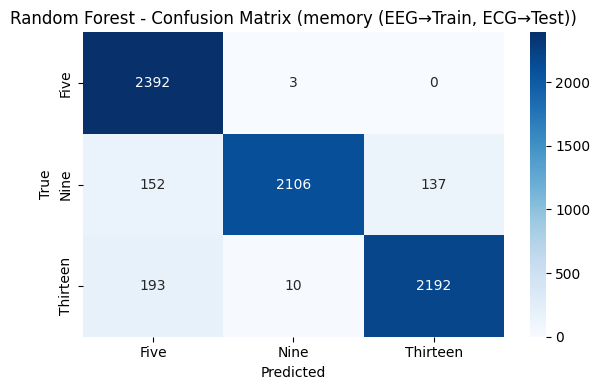

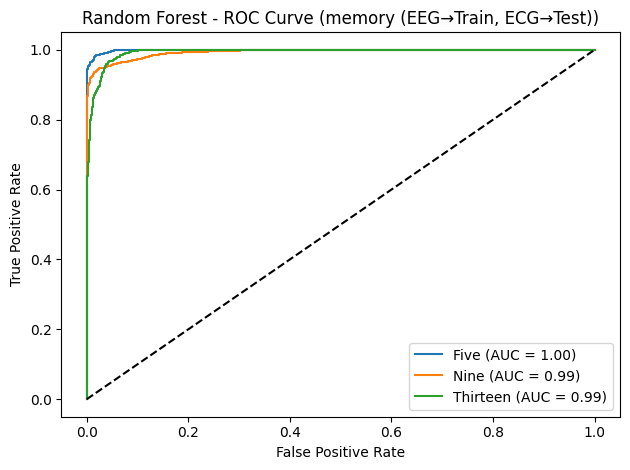

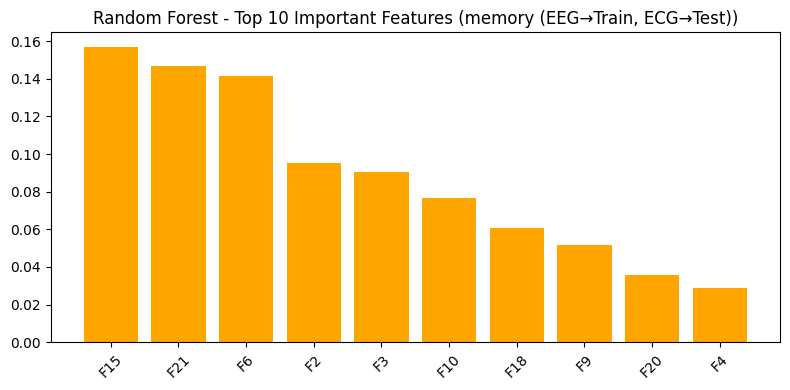


📊 Model: SVM
✅ Accuracy: 0.8296
✅ Classification Report:
               precision    recall  f1-score   support

        Five       0.97      0.79      0.87      2395
        Nine       0.98      0.71      0.82      2395
    Thirteen       0.68      0.99      0.80      2395

    accuracy                           0.83      7185
   macro avg       0.88      0.83      0.83      7185
weighted avg       0.88      0.83      0.83      7185

✅ Confusion Matrix:
 [[1898    9  488]
 [  48 1701  646]
 [   9   24 2362]]


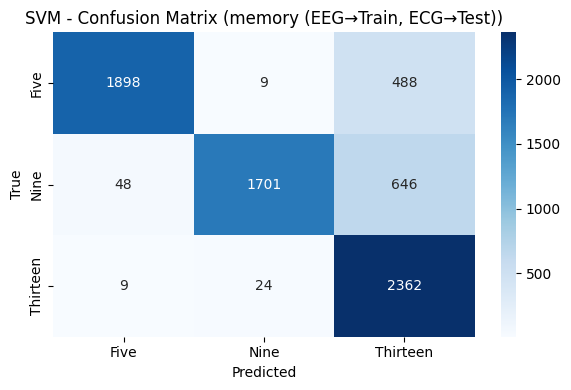

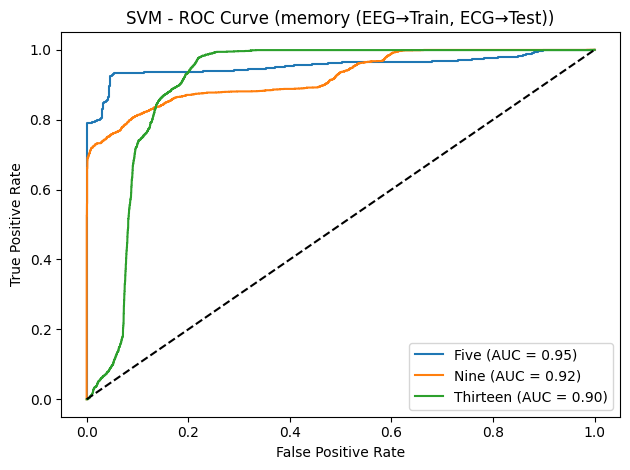


📊 Model: XGBoost
✅ Accuracy: 0.8767
✅ Classification Report:
               precision    recall  f1-score   support

        Five       0.94      0.98      0.96      2395
        Nine       0.77      0.97      0.86      2395
    Thirteen       0.99      0.68      0.80      2395

    accuracy                           0.88      7185
   macro avg       0.90      0.88      0.87      7185
weighted avg       0.90      0.88      0.87      7185

✅ Confusion Matrix:
 [[2340   55    0]
 [  42 2332   21]
 [ 120  648 1627]]


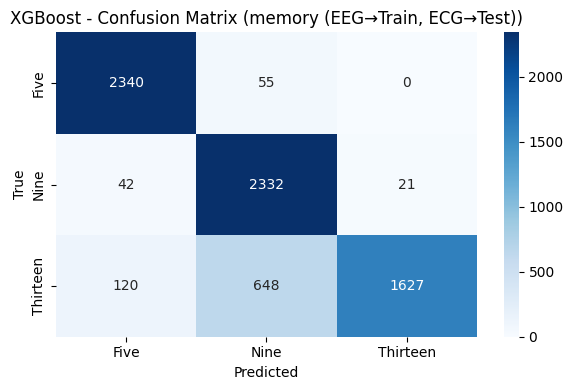

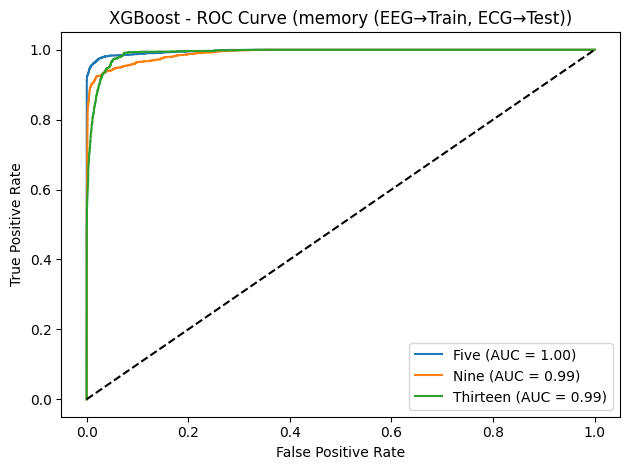

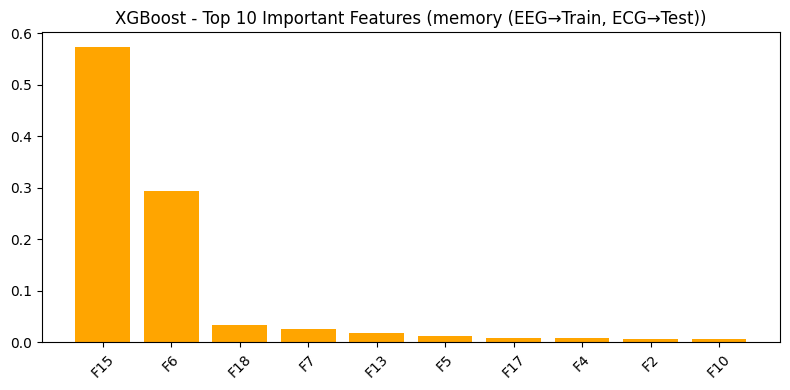

In [ ]:
# === Run All Tasks ===
run_fusion("memory", label_names=["Five", "Nine", "Thirteen"])


🧪 Running Fusion Mode: BINARY (EEG → Train, ECG → Test)


100%|██████████| 9737/9737 [03:03<00:00, 53.16it/s]


⚖️ Balancing EEG Training Data...
🔁 Balanced Class Distribution: Counter({np.int64(0): 6660, np.int64(1): 6660})


100%|██████████| 10241/10241 [03:12<00:00, 53.23it/s]


⚖️ Balancing ECG Testing Data...
🔁 Balanced Class Distribution: Counter({np.int64(0): 6990, np.int64(1): 6990})

📚 Task: binary (EEG→Train, ECG→Test)
🔢 ECG Train Class Distribution: Counter({np.int64(0): 6660, np.int64(1): 6660})
🔢 EEG Test Class Distribution: Counter({np.int64(0): 6990, np.int64(1): 6990})

📊 Model: Random Forest
✅ Accuracy: 0.4870
✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.47      0.21      0.29      6990
      Memory       0.49      0.77      0.60      6990

    accuracy                           0.49     13980
   macro avg       0.48      0.49      0.44     13980
weighted avg       0.48      0.49      0.44     13980

✅ Confusion Matrix:
 [[1448 5542]
 [1630 5360]]


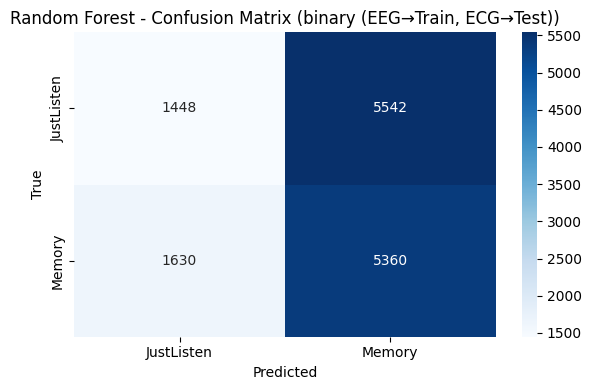

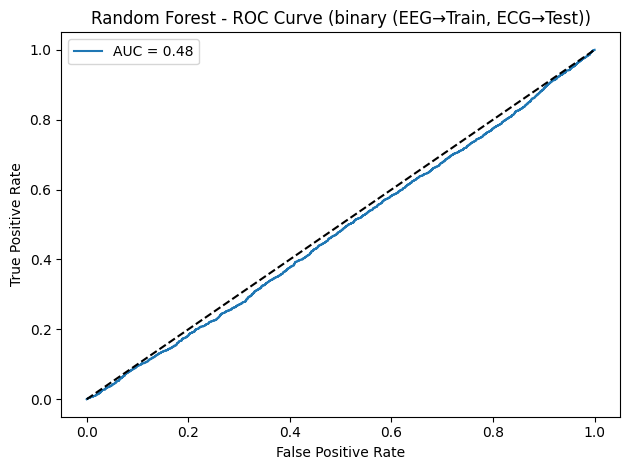

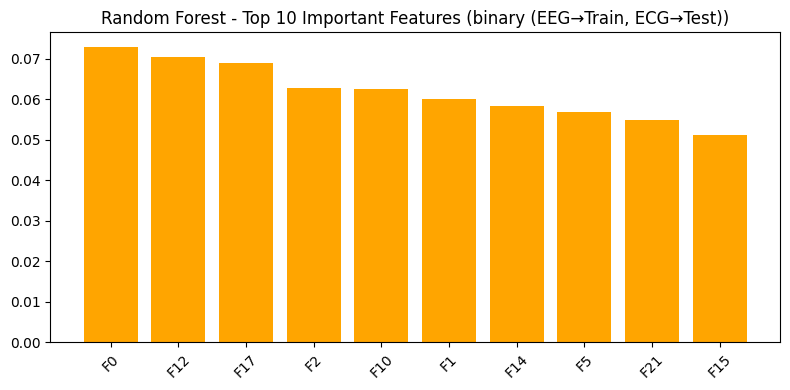


📊 Model: SVM
✅ Accuracy: 0.5000
✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.50      1.00      0.67      6990
      Memory       0.00      0.00      0.00      6990

    accuracy                           0.50     13980
   macro avg       0.25      0.50      0.33     13980
weighted avg       0.25      0.50      0.33     13980

✅ Confusion Matrix:
 [[6990    0]
 [6990    0]]


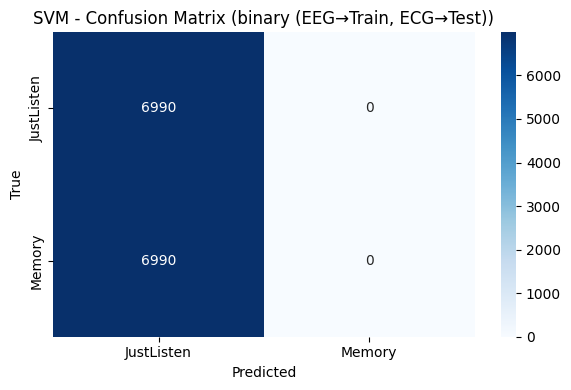

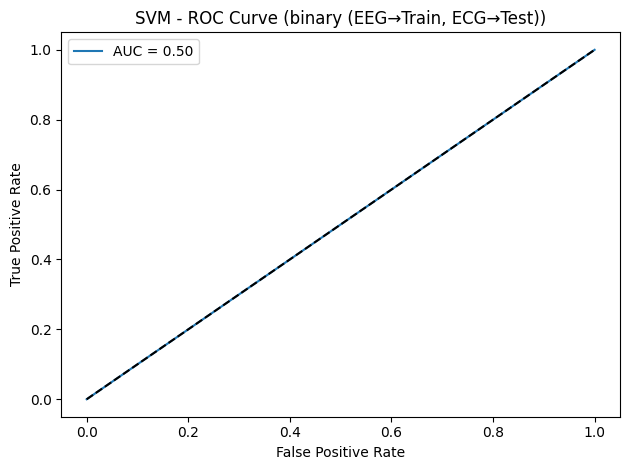


📊 Model: XGBoost
✅ Accuracy: 0.4969
✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.49      0.25      0.33      6990
      Memory       0.50      0.74      0.60      6990

    accuracy                           0.50     13980
   macro avg       0.50      0.50      0.46     13980
weighted avg       0.50      0.50      0.46     13980

✅ Confusion Matrix:
 [[1758 5232]
 [1802 5188]]


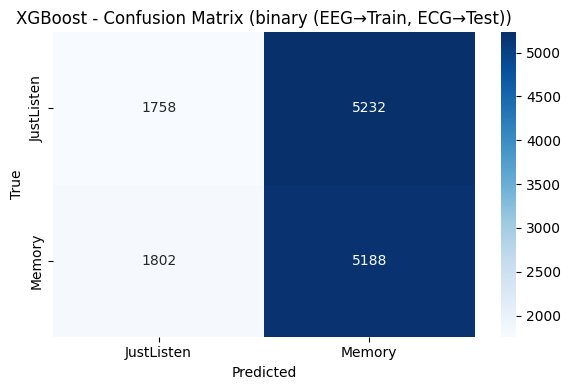

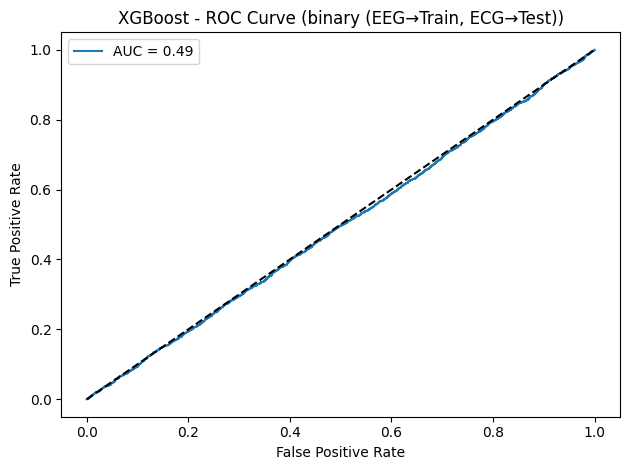

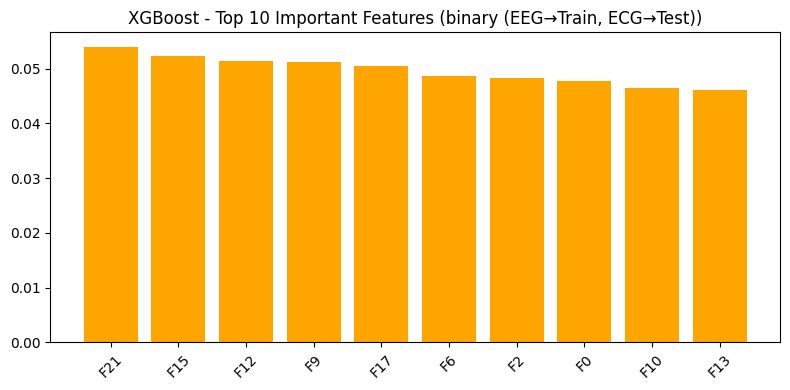

In [ ]:
run_fusion("binary", label_names=["JustListen", "Memory"])


🧪 Running Fusion Mode: 4CLASS (EEG → Train, ECG → Test)
⚖️ Balancing EEG Training Data...
🔁 Balanced Class Distribution: Counter({np.int64(0): 3077, np.int64(1): 3077, np.int64(2): 3077, np.int64(3): 3077})


100%|██████████| 12308/12308 [03:51<00:00, 53.06it/s]


⚖️ Balancing ECG Testing Data...
🔁 Balanced Class Distribution: Counter({np.int64(0): 3251, np.int64(1): 3251, np.int64(2): 3251, np.int64(3): 3251})


100%|██████████| 13004/13004 [04:07<00:00, 52.54it/s]



📚 Task: 4class (EEG→Train, ECG→Test)
🔢 ECG Train Class Distribution: Counter({np.int64(0): 3077, np.int64(1): 3077, np.int64(2): 3077, np.int64(3): 3077})
🔢 EEG Test Class Distribution: Counter({np.int64(0): 3251, np.int64(1): 3251, np.int64(2): 3251, np.int64(3): 3251})

📊 Model: Random Forest
✅ Accuracy: 0.6969
✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.28      0.04      0.08      3251
        Five       0.69      0.99      0.81      3251
        Nine       0.75      0.85      0.80      3251
    Thirteen       0.71      0.90      0.80      3251

    accuracy                           0.70     13004
   macro avg       0.61      0.70      0.62     13004
weighted avg       0.61      0.70      0.62     13004

✅ Confusion Matrix:
 [[ 144 1178  925 1004]
 [  32 3219    0    0]
 [ 150  151 2766  184]
 [ 184  133    1 2933]]


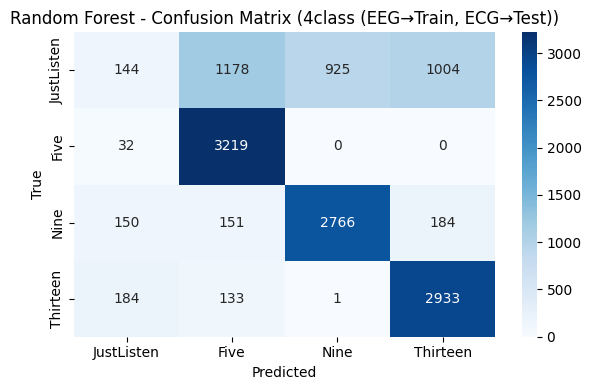

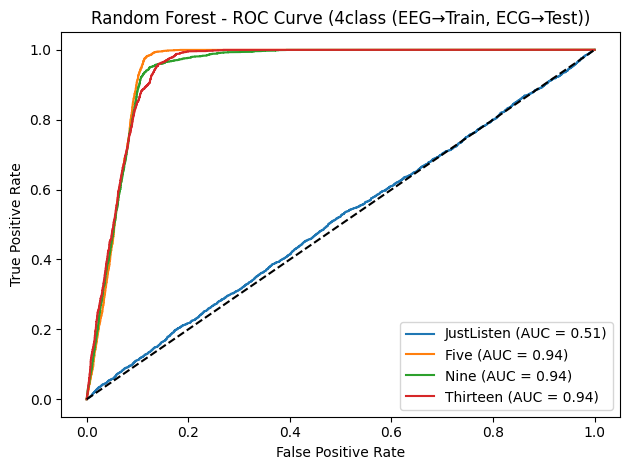

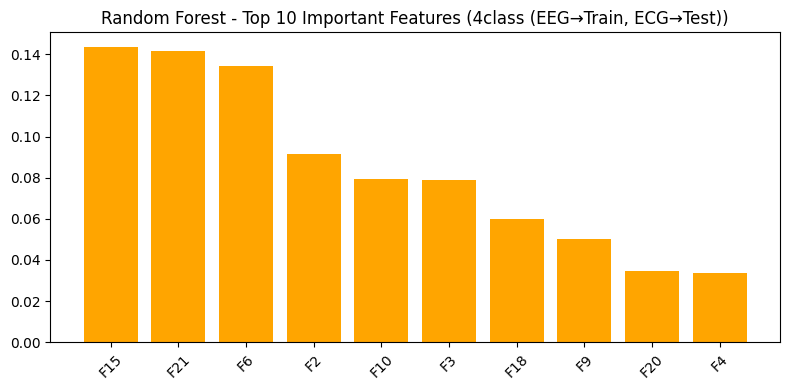


📊 Model: SVM
✅ Accuracy: 0.6269
✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.31      0.03      0.05      3251
        Five       0.75      0.80      0.77      3251
        Nine       0.74      0.70      0.72      3251
    Thirteen       0.52      0.98      0.68      3251

    accuracy                           0.63     13004
   macro avg       0.58      0.63      0.56     13004
weighted avg       0.58      0.63      0.56     13004

✅ Confusion Matrix:
 [[  97  869  771 1514]
 [  34 2593    4  620]
 [ 157    5 2262  827]
 [  27    6   18 3200]]


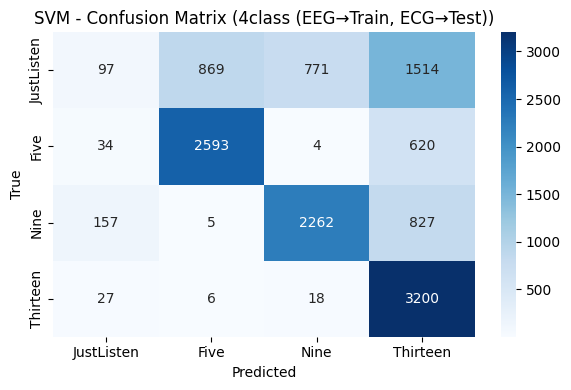

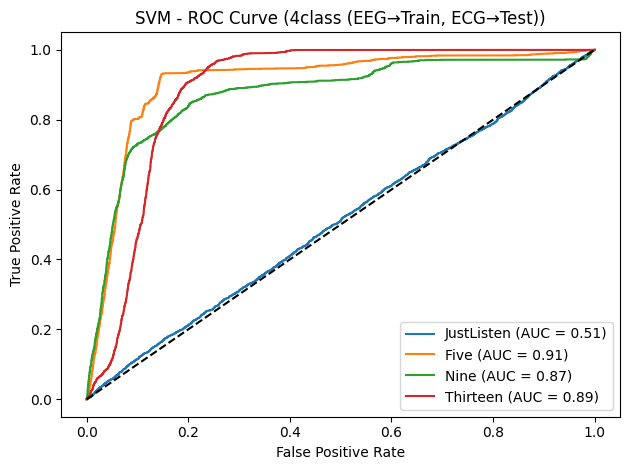


📊 Model: XGBoost
✅ Accuracy: 0.6179
✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.26      0.25      0.26      3251
        Five       0.74      0.95      0.83      3251
        Nine       0.70      0.90      0.79      3251
    Thirteen       0.76      0.37      0.50      3251

    accuracy                           0.62     13004
   macro avg       0.62      0.62      0.59     13004
weighted avg       0.62      0.62      0.59     13004

✅ Confusion Matrix:
 [[ 810 1034 1041  366]
 [ 154 3076   21    0]
 [ 291   13 2933   14]
 [1820   26  189 1216]]


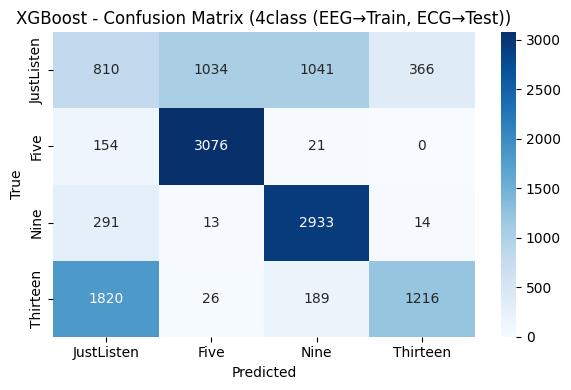

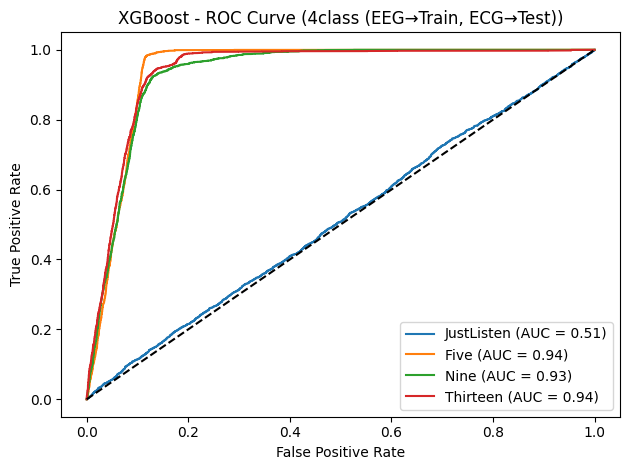

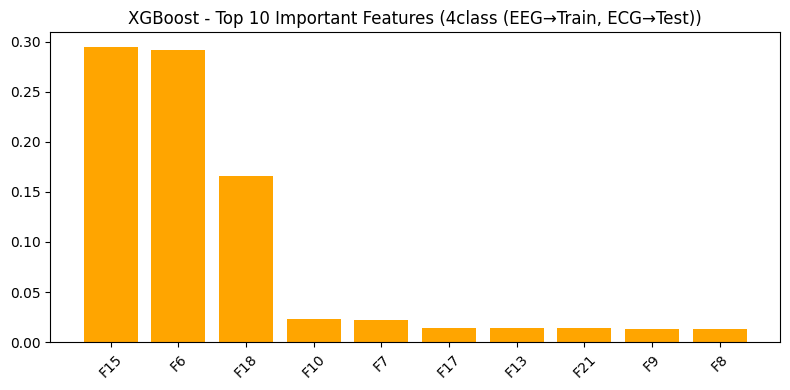

In [ ]:
run_fusion("4class", label_names=["JustListen", "Five", "Nine", "Thirteen"])